In [1]:
# Script to have different ways to train the tactile image
import glob
import h5py
import hydra
import mmap
import numpy as np
import os
import pickle
import torch 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.utils.data as data 

from omegaconf import DictConfig, OmegaConf
from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP
from holobot.robot.allegro.allegro_kdl import AllegroKDL

from tactile_learning.utils.constants import *
from tactile_learning.models.custom import *
from tactile_learning.datasets.tactile_vision import *
from tactile_learning.deployment.load_models import * 
from tactile_learning.deployment.nn_buffer import NearestNeighborBuffer
from tactile_learning.models.knn import KNearestNeighbors, ScaledKNearestNeighbors
from tactile_learning.utils.visualization import *
from tactile_learning.utils.tactile_image import *
from tactile_learning.utils.data import load_data


# Linear Layer to each Tactile Sensor
Here the approach will be as follows: 
1. Turn each small tactile sensor to an image
2. In BYOL after applying the augmentations (which only could be) the encoder will flatten the data
3. And then we'll just have multiple linear layers on top

## Load the data 
Load the data from the play dataset

In [2]:
PLAY_DATA_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data'
PLAY_ROOTS = glob.glob(f'{PLAY_DATA_DIR}/demonstration_*')
play_data = load_data(PLAY_ROOTS)


In [3]:
tactile_value = play_data['tactile']['values']

In [4]:
DEMO_ID = 11
TACTILE_ID = 2000
tactile_values = play_data['tactile']['values'][DEMO_ID][TACTILE_ID]

## Utils methods

In [5]:
from tactile_learning.utils.visualization import plot_tactile_sensor
def plot_tactile_image(ax, tactile_image): # Tactile image should be tensor
    # Map it to 0 and 1 - not super certain this is correct
    min, max = tactile_image.min(), tactile_image.max()
    img_range = max - min
    img = (tactile_image - min) / img_range
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

In [6]:
def get_small_tactile_image(tactile_value): # tactile_value.shape: (16,3)
    tactile_image = torch.FloatTensor(tactile_value)
    tactile_image = tactile_image.view(4,4,3)
    return torch.permute(tactile_image, (2,0,1))

In [7]:
ex_tact_value = tactile_values[7,:]
ex_tact_img = get_small_tactile_image(ex_tact_value)

## Find the whole mean and std of this images

In [8]:
# Find the whole mean and stds of this data

def get_tactile_image_stats(tactile_values): # tactile_values: data['tactile']['values']
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    pbar = tqdm(total=len(tactile_values.keys()))
    # loop through the images
    total_num_imgs = 0
    for demo_id in tactile_values.keys(): 
        for tactile_id in range(len(tactile_values[demo_id])):
            curr_tactile_values = tactile_values[demo_id][tactile_id]
            for sensor_id in range(curr_tactile_values.shape[0]): # 15
                tactile_img = get_small_tactile_image(curr_tactile_values[sensor_id]).unsqueeze(0) # Act as if this is a batch
                psum += tactile_img.sum(axis = [0,2,3])
                psum_sq += (tactile_img ** 2).sum(axis = [0, 2, 3])
                total_num_imgs += 1
        pbar.update(1)
        pbar.set_description(f'Demo: {demo_id}')

    pbar.close()

    # pixel count
    count = total_num_imgs * 4 * 4

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    # print('mean: '  + str(total_mean))
    # print('std:  '  + str(total_std))

    return total_mean, total_std

In [9]:
TACTILE_MEAN, TACTILE_STD = get_tactile_image_stats(play_data['tactile']['values'])

Demo: 12: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


In [10]:
print('mean: {}, std: {}'.format(TACTILE_MEAN, TACTILE_STD))

mean: tensor([-6.9900,  3.7022, 10.7355]), std: tensor([189.6929, 156.1941, 132.6691])


In [11]:
def get_augmentations(img_means, img_stds):
    tactile_aug = T.Compose([
        T.RandomApply(
            nn.ModuleList([T.RandomResizedCrop((4,4), scale=(.75, 1))]),
            p = 0.5
        ), 
        T.RandomApply(
            nn.ModuleList([T.GaussianBlur((3, 3), (1.0, 2.0))]), 
            p = 0.5
        ),
        T.Normalize(
            mean = img_means, # NOTE: Wasn't this wrong?
            std = img_stds
        )
    ])
    return tactile_aug

Text(0.5, 1.0, 'Augmented Image')

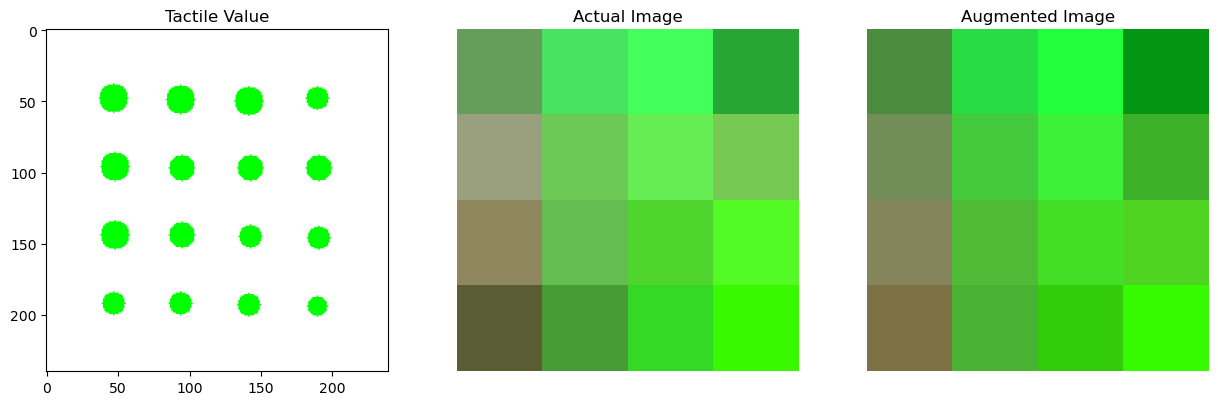

In [12]:
DEMO_ID = 11
TACTILE_ID = 2000 #2126
SENSOR_ID = 7
tactile_values = play_data['tactile']['values'][DEMO_ID][TACTILE_ID]

ex_tact_value = tactile_values[SENSOR_ID,:]
ex_tact_img = get_small_tactile_image(ex_tact_value)
tactile_aug = get_augmentations(TACTILE_MEAN, TACTILE_STD)
ex_tact_aug_img = tactile_aug(ex_tact_img)
norm_transform = T.Normalize(
    mean = TACTILE_MEAN, std = TACTILE_STD
)
ex_tact_norm_img = norm_transform(ex_tact_img)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_tactile_sensor(axs[0], ex_tact_value)
axs[0].set_title('Tactile Value')
plot_tactile_image(axs[1], ex_tact_norm_img)
axs[1].set_title('Actual Image')
plot_tactile_image(axs[2], ex_tact_aug_img)
axs[2].set_title('Augmented Image')

## Different Encoder Types
1. After normalizing just flatten it
2. Have a separate CNN for each tactile sensor
3. 16x3 channeled CNN

### Implement the only sensor tactile dataset
This dataset should give only sensor tactile images

In [13]:

def get_single_tactile_image(tactile_value):
    tactile_image = torch.FloatTensor(tactile_value)
    tactile_image = tactile_image.view(4,4,3)
    return torch.permute(tactile_image, (2,0,1))

class TactileSensorDataset(data.Dataset):
    def __init__(
        self,
        data_path,
        normalize=False,
        stats=[TACTILE_MEAN, TACTILE_STD], # Will have image means and stds
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)
        self.data = load_data(self.roots, demos_to_use=[])
        self.normalize = normalize
        self.normalization_transform = T.Normalize(stats[0], stats[1])
        self._preprocess_tactile_indices()

    def _preprocess_tactile_indices(self):
        self.tactile_mapper = np.zeros(len(self.data['tactile']['indices'])*15).astype(int)
        for data_id in range(len(self.data['tactile']['indices'])):
            for sensor_id in range(15):
                self.tactile_mapper[data_id*15+sensor_id] = data_id # Assign each finger to an index basically

    def _get_sensor_id(self, index):
        return index % 15

    def __len__(self):
        return len(self.tactile_mapper)

    def __getitem__(self, index):
        data_id = self.tactile_mapper[index]
        demo_id, tactile_id = self.data['tactile']['indices'][data_id]
        sensor_id = self._get_sensor_id(index)

        # Get the tactile image
        tactile_value = self.data['tactile']['values'][demo_id][tactile_id][sensor_id]
        tactile_image = get_single_tactile_image(tactile_value)

        if self.normalize:
            return self.normalization_transform(tactile_image)
        else:
            return tactile_image

    def getitem(self, index):
        return self.__getitem__(index) # NOTE: for debugging purposes

In [14]:
dset = TactileSensorDataset(data_path = PLAY_DATA_DIR, normalize=True, stats = [TACTILE_MEAN, TACTILE_STD])
tactile_loader = data.DataLoader(dset, 
                                batch_size  = 32, 
                                shuffle     = True, 
                                num_workers = 4,
                                pin_memory  = True)


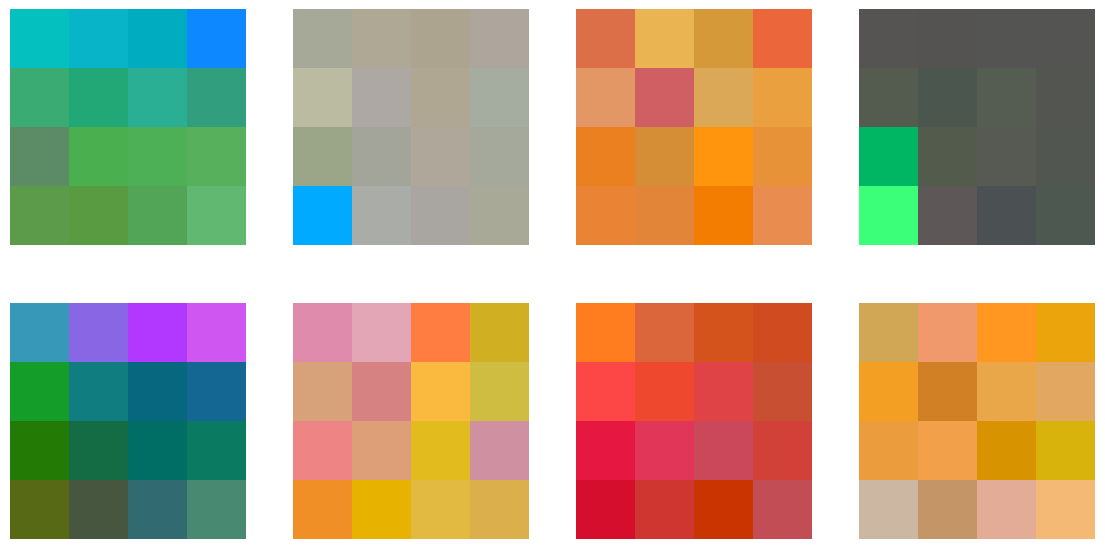

In [15]:
# display images
for batch_idx, inputs in enumerate(tactile_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plot_tactile_image(ax, inputs[i])
        # plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

## Train these encoders with BYOL

### LinearEncoder
*Encoder* that just flattens the data - after defining the optimizer and adataloaders and stuff we'll use this

In [16]:
class PrintSize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x.shape)
        return x

class TactileLinearEncoder(nn.Module):
    def __init__(
        self,
        input_dim = 48,
        hidden_dim = 128,
        output_dim = 64
    ):
        super().__init__() 
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # Flatten the image
        x = torch.flatten(x,1)
        x = self.model(x)
        return x

class TactileSmallEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),
            nn.ReLU(),
            # PrintSize()
        )
        self.linear = nn.Linear(in_features=128, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)

class TactileStackedEncoder(nn.Module): # Model for 16x3 RGB channelled images
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=2),
            nn.ReLU(),
            PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
            nn.ReLU(),
            PrintSize(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2),
            nn.ReLU(),
            PrintSize()
        )
        self.linear = nn.Linear(in_features=128, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)

In [17]:

from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam
from torch.utils.data import DataLoader

augment_fn = get_augmentations(TACTILE_IMAGE_MEANS, TACTILE_IMAGE_STDS) # One augment_fn is enough (since it will be the same as augment2)
image_size = 4
learner = BYOL(
    # net = TactileLinearEncoder(
    #     input_dim = 48, # 16 * 3
    #     hidden_dim = 128, 
    #     output_dim = 64
    # ), 
    net = TactileSmallEncoder(
        in_channels=3,
        out_dim=64
    ),
    image_size = image_size,
    augment_fn = augment_fn,
    hidden_layer=-1
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)

dataset = TactileSensorDataset(data_path = PLAY_DATA_DIR, normalize = True)
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

In [18]:
def train_one_epoch(learner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    pbar = tqdm(total=len(dataloader))
    timestep = 0
    for batch in tqdm(dataloader):
        tactile_image = batch
        optimizer.zero_grad()
        loss = learner(tactile_image) 

        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()
        pbar.set_description(f'Train Loss: {loss.item()}')
        pbar.update(1)

        timestep += 1
        if timestep % 100:
            torch.save(learner.state_dict(),
                       'linear_encoder.pt',
                        _use_new_zipfile_serialization=False)

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

In [19]:
average_loss = train_one_epoch(learner, dataloader, optimizer)

  4%|▎         | 1280/35525 [07:44<3:26:56,  2.76it/s]/35525 [07:43<2:40:07,  3.56it/s]  


KeyboardInterrupt: 